## The Baseball Labor Market's Valuation of On-Base and Slugging Percentage

### Reproducing Hakes and Sauer Table 3

### Import neccesary modules

In [233]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

# Salary Data

### Load in Salary Data

In [234]:
Salaries = pd.read_csv('MLBsalaries.csv')
display(Salaries)

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000
...,...,...,...,...,...
26423,2016,WAS,NL,strasst01,10400000
26424,2016,WAS,NL,taylomi02,524000
26425,2016,WAS,NL,treinbl01,524900
26426,2016,WAS,NL,werthja01,21733615


### Salary Data Cleaning and Manipulation

In [235]:
Salaries = Salaries[Salaries.salary > 0]
Salaries = Salaries.rename(columns = {'yearID':'SalYear'})

### Calculate natural log of salaries

In [236]:
Salaries['lnSal'] = np.log(Salaries['salary'])

### Create a master df to merge more columns onto

In [237]:
master_df = Salaries

# Batting Data

### Load in Batting Data

In [238]:
Batting = pd.read_csv('MLBbatting.csv')

### Batting Data Cleaning and Manipulation

In [239]:
# Account for player who play for multiple teams in a single season
Batting = Batting.groupby(['playerID','yearID']).sum()
Batting.reset_index(inplace=True)

# Refine Batting Data to 1990 to 2016
# And to batters with over 130 at bats (rookie threshold)
Batting = Batting[(Batting.yearID >= 1990) & (Batting.yearID <= 2016) & (Batting.AB >= 130)].copy()

### Calculate PA, OBP and SLG

Plate Appearances: PA = AB+BB+SH+SF

On Base Percentage: OBP = (H+BB+HBP) / (AB+BB+HBP+SF)

SLugging: SLG = (1B+ 2(2B) + 3(3B) + 4(HR)) / AB

    Singles: 1B = (H-2B-3B-HR)

In [240]:
Batting['Singles'] = Batting['H'] - Batting['Doubles'] - Batting['Triples'] - Batting['HR']

Batting['PA'] = Batting['AB'] + Batting['BB'] + Batting['HBP'] + Batting['SH'] + Batting['SF']

Batting['OBP'] = (Batting['H'] + Batting['BB'] + Batting['HBP']) /\
                 (Batting['AB'] + Batting['BB'] + Batting['HBP'] + Batting['SF'])

Batting['SLG'] = (Batting['Singles'] + 2*Batting['Doubles'] + 3*Batting['Triples'] + 4*Batting['HR'])/Batting['AB']

### Create variable that links previous seasons stats to next years salary in batting data

In [241]:
Batting['SalYear'] = Batting['yearID'] + 1

In [242]:
Batting

,playerID,yearID,stint,G,AB,R,H,Doubles,Triples,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,Singles,PA,OBP,SLG,SalYear
98,abbotje01,1998,1,89,244,33,68,14,1,12,41.0,3.0,3.0,9,28.0,1.0,0.0,2.0,5.0,2.0,41,260.0,0.298450,0.491803,1999
100,abbotje01,2000,1,80,215,31,59,15,1,3,29.0,2.0,1.0,21,38.0,1.0,2.0,2.0,1.0,2.0,40,241.0,0.343096,0.395349,2001
113,abbotku01,1994,1,101,345,41,86,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,57,371.0,0.290761,0.394203,1995
114,abbotku01,1995,1,120,420,60,107,18,7,17,60.0,4.0,3.0,36,110.0,4.0,5.0,2.0,5.0,6.0,65,468.0,0.317597,0.452381,1996
115,abbotku01,1996,1,109,320,37,81,18,7,8,33.0,3.0,3.0,22,99.0,1.0,3.0,4.0,0.0,7.0,48,349.0,0.307246,0.428125,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95217,zuninmi01,2014,1,131,438,51,87,20,2,22,60.0,0.0,3.0,17,158.0,1.0,17.0,0.0,4.0,12.0,43,476.0,0.254202,0.404110,2015
95218,zuninmi01,2015,1,112,350,28,61,11,0,11,28.0,0.0,1.0,21,132.0,0.0,5.0,8.0,2.0,6.0,39,386.0,0.230159,0.300000,2016
95219,zuninmi01,2016,1,55,164,16,34,7,0,12,31.0,0.0,0.0,21,65.0,0.0,6.0,0.0,1.0,0.0,15,192.0,0.317708,0.469512,2017
95221,zupcibo01,1992,1,124,392,46,108,19,1,3,43.0,2.0,2.0,25,60.0,1.0,4.0,7.0,4.0,6.0,85,432.0,0.322353,0.352041,1993


### Merge batting data onto master df

In [243]:
master_df = pd.merge(Batting, master_df, on=['SalYear', 'playerID'])

# Biographical Data

### Read in biographical data

In [244]:
Bios = pd.read_csv('MLBbios.csv')
Bios

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,NaN,NaN,NaN,David,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,NaN,NaN,NaN,Hank,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,USA,GA,Atlanta,Tommie,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,NaN,NaN,NaN,Don,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,NaN,NaN,NaN,Andy,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19365,zupofr01,1939.0,8.0,29.0,USA,CA,San Francisco,2005.0,3.0,25.0,USA,CA,Burlingame,Frank,Zupo,Frank Joseph,182.0,71.0,L,R,1957-07-01,1961-05-09,zupof101,zupofr01
19366,zuvelpa01,1958.0,10.0,31.0,USA,CA,San Mateo,NaN,NaN,NaN,NaN,NaN,NaN,Paul,Zuvella,Paul,173.0,72.0,R,R,1982-09-04,1991-05-02,zuvep001,zuvelpa01
19367,zuverge01,1924.0,8.0,20.0,USA,MI,Holland,2014.0,9.0,8.0,USA,AZ,Tempe,George,Zuverink,George,195.0,76.0,R,R,1951-04-21,1959-06-15,zuveg101,zuverge01
19368,zwilldu01,1888.0,11.0,2.0,USA,MO,St. Louis,1978.0,3.0,27.0,USA,CA,La Crescenta,Dutch,Zwilling,Edward Harrison,160.0,66.0,L,L,1910-08-14,1916-07-12,zwild101,zwilldu01


### Narrow down to a debut df

In [245]:
Debut = Bios[['playerID','debut']].copy()
Debut['debut_yr'] = Debut['debut'].astype(str).str[0:4]
Debut = Debut[['playerID','debut_yr']]
Debut 

,playerID,debut_yr
0,aardsda01,2004
1,aaronha01,1954
2,aaronto01,1962
3,aasedo01,1977
4,abadan01,2001
...,...,...
19365,zupofr01,1957
19366,zuvelpa01,1982
19367,zuverge01,1951
19368,zwilldu01,1910


### Merge debut year onto master df

In [246]:
master_df = pd.merge(master_df, Debut, on=['playerID'], how='left')

### Calculate years of experience

In [247]:
master_df['Exp'] = master_df['yearID'] - master_df['debut_yr'].astype(int)

### Use years of experience to classify players contract statsus as: free agent or arbitration eligible

In [248]:
master_df['Arb'] = np.where((master_df['Exp'] <= 6) & (master_df['Exp'] >= 3), 1, 0)
master_df['Free'] = np.where(master_df['Exp'] > 6, 1, 0)

# Appearances per Position Data

### Read in appearance data

In [249]:
Appearances = pd.read_csv('MLBappearances.csv')

### Aggregate appearance data

In [250]:
Appearances = Appearances.groupby(['playerID','yearID'])['G_c','G_1b','G_2b','G_3b','G_ss','G_of','G_dh'].sum()                                       
Appearances.reset_index(inplace=True)

### Find max number of appearances for each position

In [251]:
Appearances['Max_G'] = Appearances[["G_c","G_1b","G_2b","G_3b","G_ss","G_of","G_dh"]].max(axis=1)

### Write a function to classify a primary position for each player

In [252]:
def Position(df):
    if (df['Max_G'] == df['G_c']): return "C"
    elif (df['Max_G'] == df['G_1b']): return "1B"
    elif (df['Max_G'] == df['G_2b']): return "2B"
    elif (df['Max_G'] == df['G_3b']): return "3B"
    elif (df['Max_G'] == df['G_ss']): return "SS"
    elif (df['Max_G'] == df['G_of']): return "OF"
    elif (df['Max_G'] == df['G_dh']): return "DH"

Appearances['POS'] = Appearances.apply(Position, axis = 1)  

### Exclude non-positional players (i.e. DH) and only keep necessary variables 

In [253]:
Appearances = Appearances[Appearances['Max_G'] > 0] 
Appearances = Appearances[['playerID','yearID','POS']]

### Create indicator variable for catcher and infielder (2B, SS, 3B)

In [254]:
Appearances['Catch'] = np.where(Appearances['POS'] == 'C', 1, 0)
Appearances['Infld'] = np.where((Appearances['POS'] == '2B') | (Appearances['POS'] == '3B') |\
                                (Appearances['POS'] == 'SS'), 1, 0)

In [255]:
Appearances

,playerID,yearID,POS,Catch,Infld
9,aaronha01,1954,OF,0,0
10,aaronha01,1955,OF,0,0
11,aaronha01,1956,OF,0,0
12,aaronha01,1957,OF,0,0
13,aaronha01,1958,OF,0,0
...,...,...,...,...,...
96596,zuvelpa01,1991,3B,0,1
96605,zwilldu01,1910,OF,0,0
96606,zwilldu01,1914,OF,0,0
96607,zwilldu01,1915,OF,0,0


### Merge Positional Data onto mater df

In [256]:
master_df = pd.merge(master_df, Appearances, on = ['playerID','yearID'], how='left')

In [257]:
master_df

,playerID,yearID,stint,G,AB,R,H,Doubles,Triples,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,Singles,PA,OBP,SLG,SalYear,teamID,lgID,salary,lnSal,debut_yr,Exp,Arb,Free,POS,Catch,Infld
0,abbotje01,1998,1,89,244,33,68,14,1,12,41.0,3.0,3.0,9,28.0,1.0,0.0,2.0,5.0,2.0,41,260.0,0.298450,0.491803,1999,CHA,AL,255000,12.449019,1997,1,0,0,OF,0,0
1,abbotje01,2000,1,80,215,31,59,15,1,3,29.0,2.0,1.0,21,38.0,1.0,2.0,2.0,1.0,2.0,40,241.0,0.343096,0.395349,2001,FLO,NL,300000,12.611538,1997,3,1,0,OF,0,0
2,abbotku01,1994,1,101,345,41,86,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,57,371.0,0.290761,0.394203,1995,FLO,NL,119000,11.686879,1993,1,0,0,SS,0,1
3,abbotku01,1995,1,120,420,60,107,18,7,17,60.0,4.0,3.0,36,110.0,4.0,5.0,2.0,5.0,6.0,65,468.0,0.317597,0.452381,1996,FLO,NL,250000,12.429216,1993,2,0,0,SS,0,1
4,abbotku01,1996,1,109,320,37,81,18,7,8,33.0,3.0,3.0,22,99.0,1.0,3.0,4.0,0.0,7.0,48,349.0,0.307246,0.428125,1997,FLO,NL,650000,13.384728,1993,3,1,0,SS,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8712,zobribe01,2014,1,146,570,83,155,34,3,10,52.0,10.0,5.0,75,84.0,4.0,1.0,2.0,6.0,8.0,108,654.0,0.354294,0.394737,2015,OAK,AL,7500000,15.830414,2006,8,0,1,2B,0,1
8713,zobribe01,2015,3,126,467,76,129,36,3,13,56.0,3.0,4.0,62,56.0,3.0,1.0,0.0,5.0,8.0,77,535.0,0.358879,0.449679,2016,CHN,NL,10500000,16.166886,2006,9,0,1,2B,0,1
8714,zuninmi01,2013,1,52,173,22,37,5,0,5,14.0,1.0,0.0,16,49.0,0.0,3.0,0.0,1.0,5.0,27,193.0,0.290155,0.329480,2014,SEA,AL,504100,13.130530,2013,0,0,0,C,1,0
8715,zuninmi01,2014,1,131,438,51,87,20,2,22,60.0,0.0,3.0,17,158.0,1.0,17.0,0.0,4.0,12.0,43,476.0,0.254202,0.404110,2015,SEA,AL,523500,13.168292,2013,1,0,0,C,1,0


# Run Necessary Regressions

### Refine master_df for years 2000 to 2004

In [258]:
Master00to04 = master_df[(master_df.SalYear >= 2000) & (master_df.SalYear <= 2004)]

In [259]:
print(Master00to04.columns.tolist())

['playerID', 'yearID', 'stint', 'G', 'AB', 'R', 'H', 'Doubles', 'Triples', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'Singles', 'PA', 'OBP', 'SLG', 'SalYear', 'teamID', 'lgID', 'salary', 'lnSal', 'debut_yr', 'Exp', 'Arb', 'Free', 'POS', 'Catch', 'Infld']


### Regression for valuation of OBP and SLG (all years : 2000-2004) ~ Table 3 Column 1

In [260]:
Val_AllYears_lm = smf.ols(formula = 'lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld', data=Master00to04).fit()
Val_AllYears_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnSal   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     485.7
Date:                Fri, 29 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:36:07   Log-Likelihood:                -1928.6
No. Observations:                1741   AIC:                             3873.
Df Residuals:                    1733   BIC:                             3917.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1090      0.164     61.773      0.000       9.788      10.430
OBP            1.4783      0.628      2.355      0.019       0.247       2.709
SLG            2.3884      0.316      7.553      0.000       1.768       3.009
PA             0.0031      0.000     25.962      0.000       0.003       0.003
Arb            1.2076      0.049     24.585      0.000       1.111       1.304
Free           1.8050      0.049     37.033      0.000       1.709       1.901
Catch          0.1115      0.057      1.972      0.049       0.001       0.222
Infld         -0.0502      0.041     -1.231      0.219      -0.130       0.030
==============================================================================
Omnibus:                        5.756   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                6.893
Skew:                           0.026   Prob(JB):                       0.0319
Kurtosis:                       3.304   Cond. No.                     1.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression for valuation of OBP and SLG (years : 2000-2003) ~ Table 3 Column 2

In [261]:
Master00to03 = master_df[(master_df.SalYear >= 2000) & (master_df.SalYear <= 2003)]
Val_00to03_lm = smf.ols(formula = 'lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld', data=Master00to03).fit()
Val_00to03_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnSal   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     423.2
Date:                Fri, 29 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:36:08   Log-Likelihood:                -1512.2
No. Observations:                1398   AIC:                             3040.
Df Residuals:                    1390   BIC:                             3082.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2248      0.176     58.008      0.000       9.879      10.571
OBP            0.7958      0.677      1.176      0.240      -0.532       2.123
SLG            2.4908      0.340      7.322      0.000       1.823       3.158
PA             0.0031      0.000     24.172      0.000       0.003       0.003
Arb            1.2559      0.054     23.432      0.000       1.151       1.361
Free           1.8729      0.053     35.018      0.000       1.768       1.978
Catch          0.1330      0.062      2.156      0.031       0.012       0.254
Infld         -0.0282      0.044     -0.639      0.523      -0.115       0.058
==============================================================================
Omnibus:                        7.962   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.336
Skew:                          -0.041   Prob(JB):                      0.00570
Kurtosis:                       3.413   Cond. No.                     1.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression for each individual year

In [262]:
Master00 = master_df[(master_df.SalYear == 2000)]
Val_00_lm = smf.ols(formula = 'lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld', data=Master00).fit()

Master01 = master_df[(master_df.SalYear == 2001)]
Val_01_lm = smf.ols(formula = 'lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld', data=Master01).fit()

Master02 = master_df[(master_df.SalYear == 2002)]
Val_02_lm = smf.ols(formula = 'lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld', data=Master02).fit()

Master03 = master_df[(master_df.SalYear == 2003)]
Val_03_lm = smf.ols(formula = 'lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld', data=Master03).fit()

Master04 = master_df[(master_df.SalYear == 2004)]
Val_04_lm = smf.ols(formula = 'lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld', data=Master04).fit()

### Display each regression in same format as Hakes and Sauer Table 3

In [263]:
Header = ['All Years','2000-2003','2000','2001','2002','2003','2004']

Table_3 = summary_col([Val_AllYears_lm, Val_00to03_lm, Val_00_lm, Val_01_lm, Val_02_lm, Val_03_lm, Val_04_lm,],\
                      regressor_order=['OBP','SLG','PA','Arb','Free','Catch','Infld','Intercept'],stars=True, \
                      float_format="'%.3f'",model_names = Header)
print(Table_3)


                All Years   2000-2003     2000        2001        2002        2003       2004   
------------------------------------------------------------------------------------------------
OBP            '1.478'**   '0.796'     '2.179'*   '0.132'     '0.595'     '1.890'     '4.353'***
               ('0.628')   ('0.677')   ('1.217')  ('1.209')   ('1.566')   ('1.585')   ('1.630') 
SLG            '2.388'***  '2.491'***  '2.550'*** '3.224'***  '2.312'***  '1.945'**   '2.171'***
               ('0.316')   ('0.340')   ('0.610')  ('0.597')   ('0.724')   ('0.846')   ('0.820') 
PA             '0.003'***  '0.003'***  '0.002'*** '0.003'***  '0.003'***  '0.003'***  '0.003'***
               ('0.000')   ('0.000')   ('0.000')  ('0.000')   ('0.000')   ('0.000')   ('0.000') 
Arb            '1.208'***  '1.256'***  '1.296'*** '1.111'***  '1.289'***  '1.247'***  '1.044'***
               ('0.049')   ('0.054')   ('0.102')  ('0.100')   ('0.114')   ('0.114')   ('0.120') 
Free           '1.805'***  '1

### Compare to original Hakes and Sauer Table 3
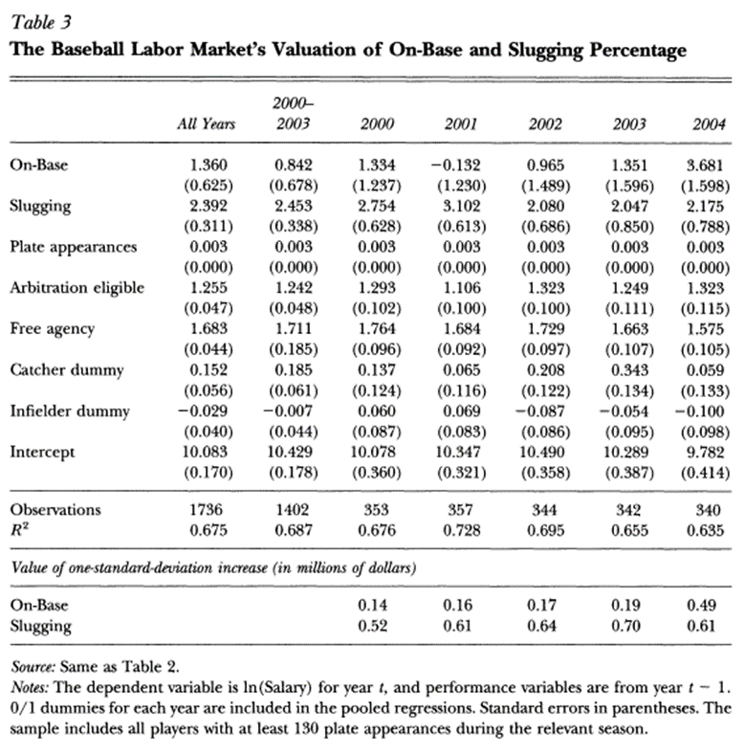

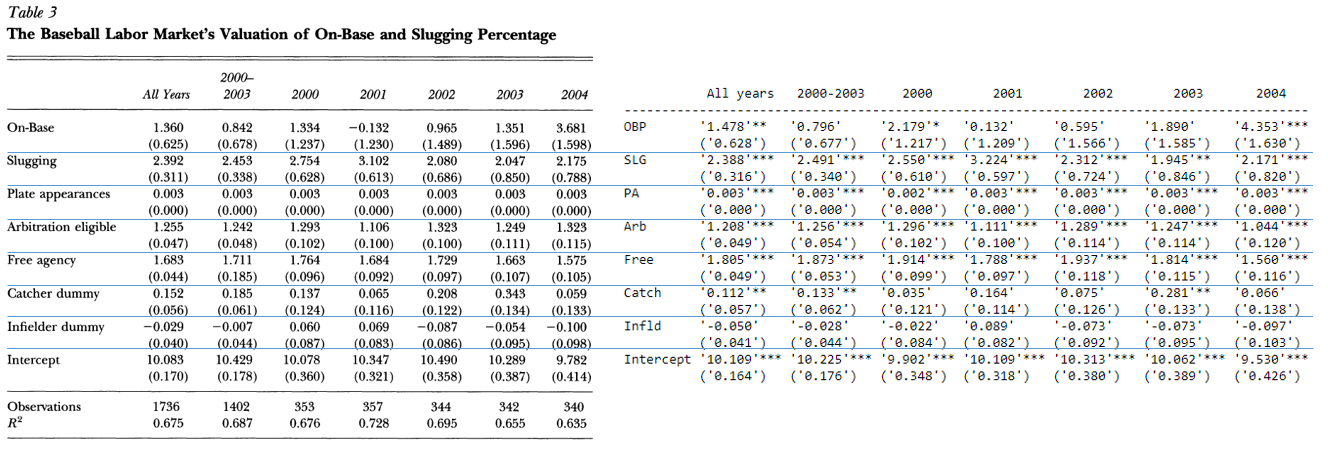

### Save master_df to csv for later use

In [265]:
master_df.to_csv('MLBmaster.csv')